# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [24]:
# There are 17 marketing campaigns in the data

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [25]:
import pandas as pd

In [26]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [27]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [29]:
# Creating new dataframe to exclude missing values and 
# rows and columns that do not contribute to the analysis

# Create new filtered dataframe which drops rows where a column contains a value labeled "unknown"
mask_unknown = (df != 'unknown').all(axis=1)
df_filtered = df[mask_unknown]

# drop duration column from filtered dataframe
# dropped based on comments about using this information to make predictions 
df_filtered.drop('duration', axis=1, inplace=True)

# drop "illiterate" from education column (small number of rows)
df_filtered = df_filtered[df_filtered['education'] != 'illiterate']

# drop "nonexistent" from poutcome column (does not contribute to the analysis)
df_filtered = df_filtered[df_filtered['poutcome'] != 'nonexistent']

# drop contact column; only 7 percent of clients contacted by cellular
df_filtered.drop('contact', axis=1, inplace=True)

# drop pdays column; significant overlap with previous column
# in terms of large numbers of people not contacted in a previous campaign
df_filtered.drop('pdays', axis=1, inplace=True)

df_filtered.info()

# Filtered dataset for analysis n = 4,651

<class 'pandas.core.frame.DataFrame'>
Index: 4651 entries, 24019 to 41187
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4651 non-null   int64  
 1   job             4651 non-null   object 
 2   marital         4651 non-null   object 
 3   education       4651 non-null   object 
 4   default         4651 non-null   object 
 5   housing         4651 non-null   object 
 6   loan            4651 non-null   object 
 7   month           4651 non-null   object 
 8   day_of_week     4651 non-null   object 
 9   campaign        4651 non-null   int64  
 10  previous        4651 non-null   int64  
 11  poutcome        4651 non-null   object 
 12  emp.var.rate    4651 non-null   float64
 13  cons.price.idx  4651 non-null   float64
 14  cons.conf.idx   4651 non-null   float64
 15  euribor3m       4651 non-null   float64
 16  nr.employed     4651 non-null   float64
 17  y               4651 non-null   o

/tmp/ipykernel_12758/2190066124.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop('duration', axis=1, inplace=True)


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [30]:
# The business objective of this task is to determine the most
# accurate classifier model to predict the factors that explain 
# the success of campaigns to have a bank client subscribe to 
# a term deposit product offered by a bank.


In [31]:
# Code to identify rows where client was not contacted and 
# subscribed to a term deposit product.

# counterfactual = df_filtered[(df_filtered['pdays'] == 999) & (df_filtered['y'] == 'yes')]
# print(counterfactual)


### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [32]:
# recode job column to binary 1 = employed 0 = unemployed
job_replace = {'admin.': 1, 'blue-collar': 1, 'entrepreneur': 1, 'management': 1,
               'self-employed': 1, 'services': 1, 'technician': 1, 
               'housemaid': 0, 'retired': 0, 'student': 0, 'unemployed': 0}
df_filtered['job'] = df_filtered['job'].replace(job_replace)

# recode marital column to binary 1 = married 0 = not married
marital_replace = {'married': 1, 'divorced': 0, 'single': 0, 'student': 0, 'unemployed': 0}
df_filtered['marital'] = df_filtered['marital'].replace(marital_replace)

# recode education column to binary 1 = university or professional 0 = secondary or basic
education_replace = {'professional.course': 1, 'university.degree': 1, 'high.school': 0, 'basic.9y': 0,
                     'basic.6y': 0, 'basic.4y': 0}
df_filtered['education'] = df_filtered['education'].replace(education_replace)

# recode default column to binary 1 = credit in default 0 = credit not in default
default_replace = {'no': 1, 'yes': 0}
df_filtered['default'] = df_filtered['default'].replace(default_replace)

# recode housing column to binary 1 = has housing loan 0 = no housing loan
housing_replace = {'no': 0, 'yes': 1}
df_filtered['housing'] = df_filtered['housing'].replace(housing_replace)

# recode loan column to binary 1 = has personal loan 0 = no personal loan
loan_replace = {'no': 0, 'yes': 1}
df_filtered['loan'] = df_filtered['loan'].replace(loan_replace)

# Create dummy variables for each month
df_filtered = pd.get_dummies(df_filtered, columns=['month'], prefix='Month')
boolean_months = ['Month_apr', 'Month_aug', 'Month_dec', 'Month_jul', 'Month_jun', 
                  'Month_mar', 'Month_may', 'Month_nov', 'Month_oct', 'Month_sep']
df_filtered[boolean_months] = df_filtered[boolean_months].astype(int)

# Create dummy variables for each day of the week
df_filtered = pd.get_dummies(df_filtered, columns=['day_of_week'], prefix='Day')
boolean_days = ['Day_mon', 'Day_tue', 'Day_wed', 'Day_thu', 'Day_fri']
df_filtered[boolean_days] = df_filtered[boolean_days].astype(int)

# recode poutcome column to binary 1 = success 0 = failure
poutcome_replace = {'failure': 0, 'success': 1}
df_filtered['poutcome'] = df_filtered['poutcome'].replace(poutcome_replace)

# recode y (target variable) column to binary 1 = subscribed to term deposit 0 = did not subscribe
y_replace = {'no': 0, 'yes': 1}
df_filtered['y'] = df_filtered['y'].replace(y_replace)

# df_filtered.value_counts('y')
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4651 entries, 24019 to 41187
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4651 non-null   int64  
 1   job             4651 non-null   int64  
 2   marital         4651 non-null   int64  
 3   education       4651 non-null   int64  
 4   default         4651 non-null   int64  
 5   housing         4651 non-null   int64  
 6   loan            4651 non-null   int64  
 7   campaign        4651 non-null   int64  
 8   previous        4651 non-null   int64  
 9   poutcome        4651 non-null   int64  
 10  emp.var.rate    4651 non-null   float64
 11  cons.price.idx  4651 non-null   float64
 12  cons.conf.idx   4651 non-null   float64
 13  euribor3m       4651 non-null   float64
 14  nr.employed     4651 non-null   float64
 15  y               4651 non-null   int64  
 16  Month_apr       4651 non-null   int64  
 17  Month_aug       4651 non-null   i

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [33]:
from sklearn.model_selection import train_test_split


In [34]:
# Train-Test split (20 percent for test data)
X = df_filtered.drop(columns = ['y'])  # Features
y = df_filtered['y']          # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3720, 30)
X_test shape: (931, 30)
y_train shape: (3720,)
y_test shape: (931,)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [35]:
# Use the ! prefix to run shell commands in Jupyter
# !conda config --add channels defaults
# !conda install -y conda-forge::python-graphviz
# !conda update -n base -c defaults conda --y

# NOTE: Anaconda not allowing this install to use graphviz

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import time
from sklearn.tree import DecisionTreeClassifier, plot_tree
# from sklearn.tree import graphviz
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [37]:
# Checking for imbalance in the target variable
print(y.value_counts())

# Data not imbalanced; 28 percent subscribed to a term deposit product

y
0    3364
1    1287
Name: count, dtype: int64


In [38]:
# Develop and fit baseline model using the most frequent class predicted for the training data
baseline_model = DummyClassifier(strategy='most_frequent', random_state=42)
baseline_model.fit(X_train, y_train)

# Predictions on the test set
y_pred_baseline = baseline_model.predict(X_test)

# Baseline model metrics
accuracy = accuracy_score(y_test, y_pred_baseline)
precision = precision_score(y_test, y_pred_baseline, zero_division=0)
recall = recall_score(y_test, y_pred_baseline, zero_division=0)

print(f"Baseline Model Accuracy: {accuracy:.4f}")
print(f"Baseline Model Precision: {precision:.4f}")
print(f"Baseline Model Recall: {recall:.4f}")


Baseline Model Accuracy: 0.7207
Baseline Model Precision: 0.0000
Baseline Model Recall: 0.0000


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [39]:
start_time = time.perf_counter() # Record the start time

basic_logit_model = LogisticRegression(max_iter = 1000, random_state = 42)
basic_logit_model.fit(X_train, y_train)

end_time = time.perf_counter() # Record the end time
elapsed_time = end_time - start_time
print(f"elapsed time: {elapsed_time:.4f} seconds")

# # test for multicollinearity
# correlation_matrix = df_filtered.corr()
# plt.figure(figsize=(14, 12))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Matrix of Independent Variables')
# plt.show()


elapsed time: 0.0787 seconds


### Problem 9: Score the Model

What is the accuracy of your model?

In [40]:
# Login training accuracy
basic_logit_accuracy_score_train = basic_logit_model.score(X_train, y_train)
print(f"Accuracy of basic Logistic Regression model with training data: {basic_logit_accuracy_score_train:.4f}")

# Logit test accuracy
basic_logit_accuracy_score_test = basic_logit_model.score(X_test, y_test)
print(f"Accuracy of basic Logistic Regression model with test data: {basic_logit_accuracy_score_test:.4f}")

Accuracy of basic Logistic Regression model with training data: 0.8116
Accuracy of basic Logistic Regression model with test data: 0.8249


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [41]:
start_time = time.perf_counter() # Record the start time

# Convert data to numpy arrays with the correct memory layout
# Necessary to correct "AttributeError: 'Flags' object has no attribute 'c_contiguous'"
X_train_knn = np.ascontiguousarray(X_train)
y_train_knn = np.asarray(y_train)
X_test_knn = np.ascontiguousarray(X_test)
y_test_knn = np.asarray(y_test)

# Basic KNN model
basic_knn = KNeighborsClassifier()
basic_knn.fit(X_train_knn, y_train_knn)

end_time = time.perf_counter() # Record the end time
elapsed_time = end_time - start_time
print(f"elapsed time: {elapsed_time:.4f} seconds")

elapsed time: 0.0025 seconds


In [42]:

# Accuracy for KNN using training data
y_pred_knn_train = basic_knn.predict(X_train_knn)
basic_knn_train_accuracy = accuracy_score(y_train_knn, y_pred_knn_train)
print(f"Basic KNN model training data accuracy: {basic_knn_train_accuracy}")

# Accuracy for KNN using test data
y_pred_knn_test = basic_knn.predict(X_test_knn)
basic_knn_test_accuracy = accuracy_score(y_test_knn, y_pred_knn_test)
print(f"Basic KNN model test data accuracy: {basic_knn_test_accuracy}")


Basic KNN model training data accuracy: 0.8298387096774194
Basic KNN model test data accuracy: 0.7787325456498388


In [43]:
start_time = time.perf_counter() # Record the start time

# Basic Decision Tree model
basic_dt_model = DecisionTreeClassifier()
basic_dt_model.fit(X_train, y_train)

end_time = time.perf_counter() # Record the end time
elapsed_time = end_time - start_time
print(f"elapsed time: {elapsed_time:.4f} seconds")

elapsed time: 0.0350 seconds


In [44]:

# Accuracy for decision tree using training data
y_train_pred = basic_dt_model.predict(X_train)
basic_dt_accuracy_train = basic_dt_model.score(X_train, y_train)
print(f"Decision tree basic model training accuracy: {basic_dt_accuracy_train}")

# Accuracy for decision tree using test data
y_test_pred = basic_dt_model.predict(X_test)
basic_dt_accuracy_test = basic_dt_model.score(X_test, y_test)
print(f"Decision tree basic model test accuracy: {basic_dt_accuracy_test}")


Decision tree basic model training accuracy: 0.9943548387096774
Decision tree basic model test accuracy: 0.7518796992481203


In [45]:
start_time = time.perf_counter() # Record the start time

# Basic Support Vector Machine model
basic_svm_model = SVC()
basic_svm_model.fit(X_train, y_train)

end_time = time.perf_counter() # Record the end time
elapsed_time = end_time - start_time
print(f"elapsed time: {elapsed_time:.4f} seconds")

elapsed time: 0.6701 seconds


In [46]:

# Accuracy for SVM using training data
y_train_pred = basic_svm_model.predict(X_train)
basic_svm_accuracy_train = basic_svm_model.score(X_train, y_train_pred)
print(f"SVM basic model training accuracy: {basic_svm_accuracy_train}")

# Accuracy for SVM using test data
y_test_pred = basic_svm_model.predict(X_test)
basic_svm_accuracy_test = basic_svm_model.score(X_test, y_test)
print(f"SVM basic model test accuracy: {basic_svm_accuracy_test}")


SVM basic model training accuracy: 1.0
SVM basic model test accuracy: 0.7207303974221267


In [47]:
# Create dataframe to summarize results of 4 basic classifier models
results = {
    "Model": ['Logistic', 'KNN', 'Decision Tree', 'SVM'],
    "Train Time (seconds)": [0.1181, 0.0231, 0.0416, 0.6301],
    "Train Accuracy": [0.8113, 0.8298, 0.9944, 1.0],
    "Test Accuracy": [0.8367, 0.7787, 0.7551, 0.7207]
}

summary_results_basic_models = pd.DataFrame(results)
summary_results_basic_models

,Model,Train Time (seconds),Train Accuracy,Test Accuracy
0,Logistic,0.1181,0.8113,0.8367
1,KNN,0.0231,0.8298,0.7787
2,Decision Tree,0.0416,0.9944,0.7551
3,SVM,0.6301,1.0000,0.7207


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.


- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [48]:
# Improving the logistic regression model

# Pipeline to scale data and instantiate logistic regression model
logit_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logit', LogisticRegression(max_iter=1000))
])

params = {
    'logit__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logit__solver': ['liblinear', 'lbfgs'] # Explore different solvers
}

# Perform Grid Search
grid_search_logit = GridSearchCV(logit_pipeline, params, cv=5, scoring='accuracy')
grid_search_logit.fit(X_train, y_train)

# Results
print(f"Best hyperparameters found: {grid_search_logit.best_params_}")
print(f"Best cross-validation score: {grid_search_logit.best_score_:.4f}")

# 6. Evaluate the best model on the test set
best_model = grid_search_logit.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print(f"Test set accuracy with best model: {test_accuracy:.4f}")



Best hyperparameters found: {'logit__C': 0.01, 'logit__solver': 'lbfgs'}
Best cross-validation score: 0.8113
Test set accuracy with best model: 0.8260


In [49]:
# Little difference in the accuracy of the tuned model
# compared to the basic logistic regression model using defaults.

In [50]:
# Improving the KNN model
# Scale the data
# Use grid search to identify value for k that is closer to the optimal value

# Pipeline to scale the data and instantiate the KNN model
knn_pipeline = Pipeline([
    ('scale', StandardScaler()), 
    ('knn', KNeighborsClassifier()),
])
# Apply grid search to the pipeline
grid_search_knn = GridSearchCV(
    estimator=knn_pipeline, 
    param_grid={'knn__n_neighbors': list(range(1, 6))},  # Note: prefix 'knn__' for pipeline parameter
    scoring='accuracy', 
    cv=5
)

grid_search_knn.fit(X_train, y_train)

print("Best k value found:", grid_search_knn.best_params_['knn__n_neighbors'])
print("Mean cross-validated accuracy for best k:", grid_search_knn.best_score_)

best_knn_model = grid_search_knn.best_estimator_

# evaluate the best model on the test data
test_accuracy = best_knn_model.score(X_test, y_test)
print("Accuracy of the best KNN model on the test set:", test_accuracy)


Best k value found: 5
Mean cross-validated accuracy for best k: 0.7701612903225806
Accuracy of the best KNN model on the test set: 0.7948442534908701


In [51]:
# Better match of the training and test accuracy scores
# Indication that the basic model for KNN was overfit

# Accuracy substantially lower than the logistic regression model

In [52]:
# Improving the Decision Tree model
# Grid search to identify optimal parameters

dt_model = DecisionTreeClassifier()

params = {
        'max_depth': [3, 4, 5, 6, None],  # Maximum depth of the tree
        'min_samples_split': [5, 7, 10], # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 4],   # Minimum number of samples required to be at a leaf node
        'criterion': ['gini', 'entropy'] # Function to measure the quality of a split
    }

grid_search_dt = GridSearchCV(estimator = dt_model,
            param_grid = params,
            cv = 5, # Number of cross-validation folds
            scoring = 'accuracy') # Metric to optimize

grid_search_dt.fit(X_train, y_train)

print("Best parameters:", grid_search_dt.best_params_)
print("Best cross-validation score (accuracy):", grid_search_dt.best_score_)

best_dt = grid_search_dt.best_estimator_
test_accuracy = best_dt.score(X_test, y_test)
print("Test set accuracy with best model:", test_accuracy)


Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best cross-validation score (accuracy): 0.8112903225806452
Test set accuracy with best model: 0.8206229860365198


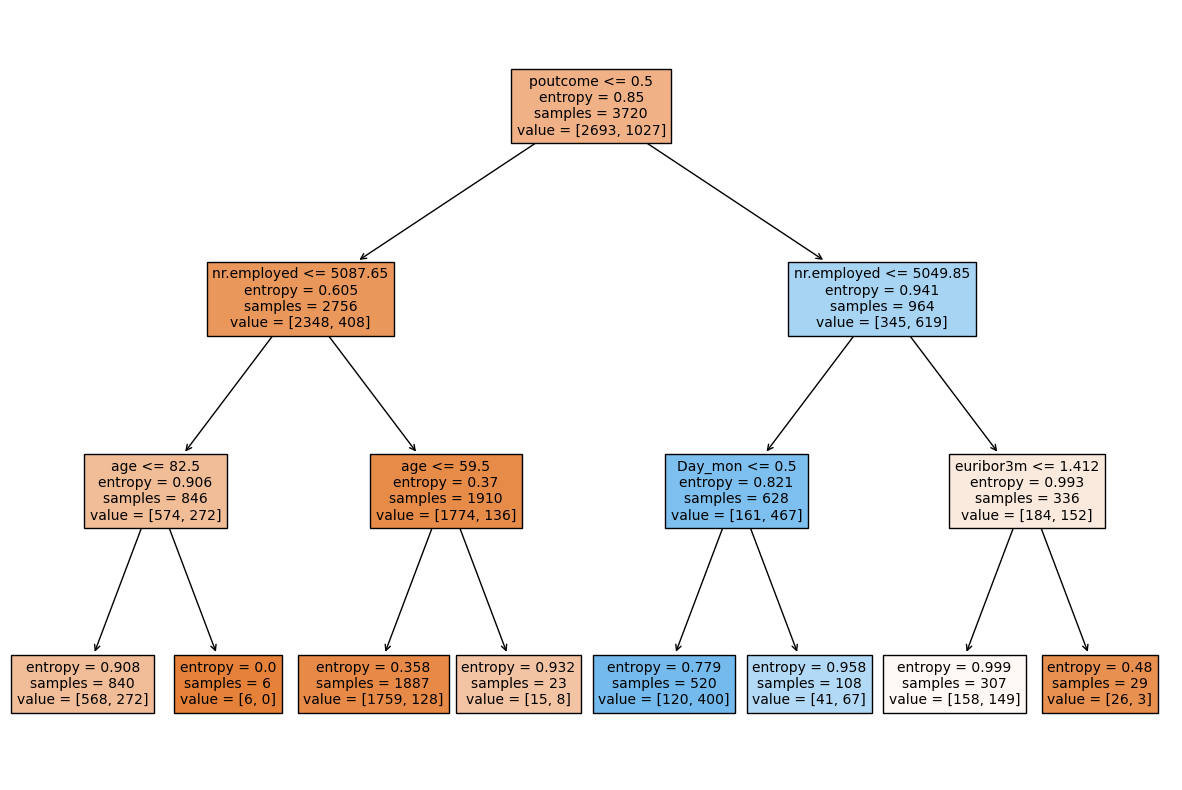

<Figure size 640x480 with 0 Axes>

In [53]:
# Display Decision Tree graphically

dt_optimized = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, 
                                      min_samples_leaf = 1, min_samples_split = 5)
dt_optimized.fit(X_train, y_train)

feature_names = X_train.columns.tolist()

plt.figure(figsize=(15, 10))
plot_tree(dt_optimized, 
          feature_names=feature_names, 
          filled=True, 
          fontsize=10)
plt.show()
plt.savefig("decision_tree.pdf")

In [54]:
# Due to a problem with Anaconda, I was unable to install graphviz
# to generate a nicer decision tree figure

# In terms of accuracy, the Decision Tree is a better choice than KNN
# and very similar to the Logistic Regression model

In [ ]:
# Improve Support Vector Machine model
# GridSearchCV took a lot of time (compute)
# Try RandomizedSearchCV to reduce processing time
# Anaconda would not complete processing of this code below or freeze up 

svm_random = SVC(random_state=42)

params = {'kernel': ['rbf', 'poly'],
         'gamma': [0.1, 1.0, 10.0],}

random_search_svm = RandomizedSearchCV(
        estimator=svm_random,
        param_distributions=params,
        n_iter=10,  # Number of random combinations to try
        cv=5,       # 5-fold cross-validation
        scoring='accuracy', # Metric to optimize
        random_state=42,
    )

random_search_svm.fit(X_train, y_train)

best_params = random_search_svm.best_params_
best_score = random_search_svm.best_score_
best_estimator = random_search_svm.best_estimator_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score:.4f}")

y_pred = best_estimator.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy with Best Model: {test_accuracy:.4f}")

In [55]:
# Explore the coeffecients for the optimized logistic regression

# Access the LogisticRegression model from the pipeline
logit_pipeline.fit(X_train, y_train)
logit_model = logit_pipeline.named_steps['logit']
coefficients = logit_model.coef_[0]
intercept = logit_model.intercept_[0]

# Get feature names
feature_names = X_train.columns

# DataFrame of the coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
print("Coefficients:")
print(coef_df)
print(f"\nIntercept: {intercept}")


Coefficients:
           Feature  Coefficient
0              age     0.082341
1              job    -0.062452
2          marital     0.016111
3        education     0.116964
4          default     0.059880
5          housing    -0.005892
6             loan    -0.018418
7         campaign    -0.099555
8         previous    -0.007362
9         poutcome     0.733875
10    emp.var.rate    -1.099012
11  cons.price.idx     1.295281
12   cons.conf.idx     0.405402
13       euribor3m    -0.224158
14     nr.employed     0.714739
15       Month_apr    -0.023006
16       Month_aug     0.092594
17       Month_dec    -0.017134
18       Month_jul    -0.032810
19       Month_jun    -0.067348
20       Month_mar     0.168608
21       Month_may    -0.048868
22       Month_nov    -0.082943
23       Month_oct     0.049503
24       Month_sep     0.093672
25         Day_fri    -0.004655
26         Day_mon    -0.082070
27         Day_thu     0.060663
28         Day_tue    -0.003594
29         Day_wed     0.0

In [ ]:
# Coefficients generally match with the decision tree model.
# The outcome of the previous marketing campaign was a strong
# positive predictor of a client subscribing to a term deposit project.


##### Questions